In [19]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import torch as pt 

import sys
import os
from tqdm import tqdm

# Add the project root
sys.path.append(os.path.abspath('../../'))

from src.useful_functions import read_dirs_paths
from src.mokito.modules2 import *

# For matplotlib
font = {'size'   : 10}
plt.rc('font', **font)
in2cm = 1/2.54  # centimeters in inches

# Read directory paths
read_dirs_paths('dir_paths.txt', globals())

device = pt.device("cuda" if pt.cuda.is_available() else "cpu")
print("")
print(device)

Created variables:
inp_dir = input/
out_trajectories1 = output/trajectories/
out_trajectories2 = output/trajectories/openmm_files/
out_trajectories3 = output/trajectories/openmm_files/initial_states/
out_trajectories4 = output/trajectories/openmm_files/final_states/
out_trajectories5 = output/trajectories/openmm_files/final_states2/
out_isokann = output/isokann/
out_mokito = output/mokito/

cuda


In [20]:
frame = 0

# Load initial and final states 
pdbfile_solute    = 'pdbfile_solute.pdb' 
file_traj_solute  = 'trajectory_solute.dcd'

mdtraj =  md.load(out_trajectories2 + file_traj_solute, top = inp_dir + pdbfile_solute)

X0     = pt.load(out_trajectories1 + 'PWDistances_0.pt', map_location=device).cpu().detach().numpy()     #  X0.shape = (N, Ndims) 

# Load chi function
chi0 = np.loadtxt(out_isokann + 'chi0.txt')     #  chi0.shape = (Npoints,)

data           =  OrganizeData( X0, chi0, MDtraj = mdtraj)

FIs    =  FindIntervals(data, Nintervals=5, clustering = 'grid')

Check shape of input data
X0.shape   =  (4000, 66)
chi0.shape =  (4000,)
  


2730
151
52
131
936


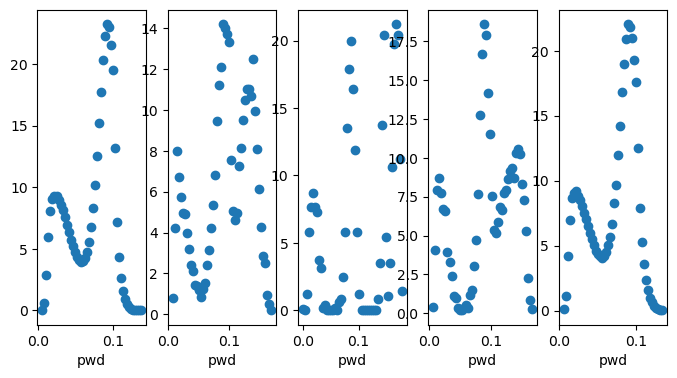

In [21]:
fig, ax = plt.subplots(1, FIs.Nintervals, figsize=(16*in2cm, 8*in2cm))  

for i in range(FIs.Nintervals):

    Xi = data.MDtraj[FIs.chi_intervals == i]
    num_conformations = Xi.n_frames
    print(num_conformations)

    distance_matrix = np.zeros((num_conformations, num_conformations))
    
    for j in range(num_conformations):
        distance_matrix[j] = md.rmsd(Xi, Xi, j)

    pwd = distance_matrix.flatten()[distance_matrix.flatten()>0]
    density, bin_edges = np.histogram(pwd, bins=50, density=True)

    ax[i].plot(bin_edges[0:-1], density, 'o')
    ax[i].set_xlabel('pwd')
    plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0.2, hspace=0.5)


In [22]:
FNs    =  FindNodes(data, FIs, eps = [0.09, 0.08, 0.09, 0.07, 0.09], 
                                 theta  = [5,5,5, 5,5], 
                                 algorithm = 'CNNC', 
                                 metric = 'mdtraj_rmsd') 
print(np.sum(FNs.nodes==-1))

print("Number of nodes:", str(FNs.Nnodes))
for i in range(FNs.Nnodes):
    print("Node, interval, size:", i, FNs.index_chi_node[i], FNs.nodes_size[i])

100%|██████████| 5/5 [00:00<00:00,  9.02it/s]

0
Number of nodes: 8
Node, interval, size: 0 0 2730
Node, interval, size: 1 1 79
Node, interval, size: 2 1 72
Node, interval, size: 3 2 20
Node, interval, size: 4 2 32
Node, interval, size: 5 3 75
Node, interval, size: 6 3 56
Node, interval, size: 7 4 936


In [23]:
BAM    =  BuildAdjacencyMatrix(data, FNs, FIs, metric = 'mdtraj_rmsd', include_same_interval=False, r_neighbors = 0.05)


BG     =  BuildGraph(FNs, BAM)
CE     =  CalculateEnergy(FNs)

G      =  BG.G

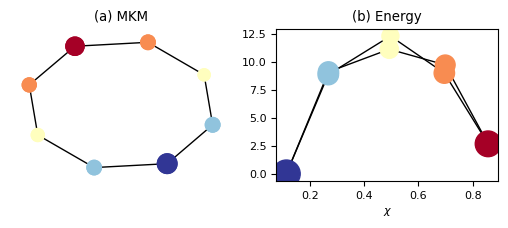

In [24]:
#posG = nx.kamada_kawai_layout(Gd)  # kamada_kawai_layout
#Make graph and nice plots
posG = nx.spring_layout(G, center=[0,0], seed = 2)  # kamada_kawai_layout

index_chi_node = FNs.index_chi_node
nodes_size     = np.log(FNs.nodes_size)*50

energy         = CE.energy
P              = BAM.P



font = {'size'   : 8}
plt.rc('font', **font)
in2cm = 1/2.54  # centimeters in inches

fig, (ax1,ax2) = plt.subplots(1, 2, figsize=(16*in2cm, 5*in2cm), facecolor='white')

nx.draw(G, 
        posG, 
        with_labels=False, 
        node_color=index_chi_node, 
        cmap = cm.RdYlBu_r, 
        node_size= nodes_size*0.5,
        edge_color='k', 
        width=1,
        ax=ax1
       )


nx.draw_networkx_nodes(G, 
                       posG, 
                       node_size=nodes_size*0.5,
                       node_color=index_chi_node, 
                       cmap = cm.RdYlBu_r, 
                       ax=ax1)

ax1.set_title('(a) MKM')

################## PLOT ENERGY
chi_nodes = ProjectFunctionOntoNodes(data, chi0, FNs, periodic=False)


for i in range(G.number_of_nodes()):
    for j in range(i+1,G.number_of_nodes()):
        if BAM.A[i,j]>0:
            ax2.plot([chi_nodes[i], chi_nodes[j]], [energy[i], energy[j]], 'k-', linewidth = 1,zorder=-1) 



ax2.scatter(chi_nodes, energy, s = nodes_size, c = index_chi_node, cmap = cm.RdYlBu_r)

ax2.set_xlabel(r'$\chi$')
ax2.set_title('(b) Energy')

#plt.subplots_adjust(left=0, bottom=0.0, right=1, top=0.99, wspace=0.0, hspace=0.0)

fig.savefig("output/figures/mokito.png", format='png', dpi=300, bbox_inches='tight')


In [25]:
nx.write_gml(G, out_mokito + "MKM.gml")

with open(out_mokito + "energy_MKM.npy", 'wb') as f:
    np.save(f, BAM.A)
    np.save(f, chi_nodes)
    np.save(f, energy)
    np.save(f, nodes_size)
    np.save(f, index_chi_node)

In [26]:
# Load relevant coordinates
R0   =  np.squeeze(md.compute_dihedrals(mdtraj, [[5,1,8,10]], periodic=True))


# Project relevant coordinates onto the nodes
R_nodes   = ProjectFunctionOntoNodes(data, R0, FNs, periodic=True)

with open(out_mokito + "rel_coords_MKM.npy", 'wb') as f:
    np.save(f, chi_nodes)
    np.save(f, nodes_size)
    np.save(f, R_nodes)

In [27]:
# The following code converts the networkx graph into a mapper graph
from collections import defaultdict
import networkx as nx
import kmapper as km
from kmapper import jupyter # Creates custom CSS full-size Jupyter screen
from kmapper.plotlyviz import mpl_to_plotly



all_chi    =  chi0

mapper = km.KeplerMapper()

graph = {
    "nodes": {},
    "links": [],
    'meta_data': {'projection': 'custom',
    'n_cubes': FNs.nodes,
    'perc_overlap': 0,
    'clusterer': 'DBSCAN(min_samples=3)',
    'scaler': 'None'},
    'meta_nodes': defaultdict(list, {})
}


# States
nodes_dict = defaultdict(list)
names_nodes = {}
states_nodemembership_x0 = FNs.nodes

for i in range(FNs.Nnodes):
    key = "cube" + str(int(i)) + "_cluster0" 
    names_nodes[i] = key

for i, node in enumerate(states_nodemembership_x0):
    key = "cube" + str(int(node)) + "_cluster0" 
    nodes_dict[key].append(i)

graph["nodes"] = nodes_dict


# Edges

a = dir(FNs)    
d_links = defaultdict(list)

adjacency_matrix = BAM.Ad

np.set_printoptions(suppress=True)

for i in range(FNs.Nnodes):
    
    key_i =  "cube" + str(i) + "_cluster0" 
    
    for j in range(i + 1):
        
        key_j = "cube" + str(j) + "_cluster0" 
        
        if adjacency_matrix[i, j] > 0:
            
            d_links[key_i].append(key_j)

graph["links"] = d_links



plotly_RdYlBu = mpl_to_plotly(cm.RdYlBu_r, 20)



"""               

mapper.visualize(graph, 
                    path_html           = out_mokito + "MKM.html",
                    color_values        = all_chi,
                    color_function_name = "labels",
                    colorscale          = plotly_RdYlBu,
                    title               = "Molecular Kinetics Map")
"""
#jupyter.display(path_html = out_mokito + "MKM.html")


'               \n\nmapper.visualize(graph, \n                    path_html           = out_mokito + "MKM.html",\n                    color_values        = all_chi,\n                    color_function_name = "labels",\n                    colorscale          = plotly_RdYlBu,\n                    title               = "Molecular Kinetics Map")\n'